In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn as sk
import scipy as sp
import regex as re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_parquet(r"train_nontemporal_classification.parquet.gz")
test=pd.read_parquet(r"test_nontemporal_classification.parquet.gz")

In [3]:
train.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,"crop production - permanent meadows, area in ha, total","crop production - permanent pastures, area in ha, total",CAQI_level,isUrban,season,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,"powiat aleksandrowski, kujawsko-pomorskie",4.746750,0.0,88.4,1.0,0.0,1.8,kujawsko-pomorskie,44.997895,1.718015,...,4.884211,0.854737,vlow,0,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat augustowski, podlaskie",8.000000,50.0,95.0,9.0,0.0,0.4,podlaskie,47.547318,4.963793,...,16.300784,2.241712,medium,0,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat bełchatowski, łódzkie",5.923833,0.0,80.0,0.0,5.0,0.0,łódzkie,43.636364,3.809493,...,7.991736,0.686983,vlow,0,Winter,New Year's Day,0.0,0.0,1.0,1
2017-01-01,"powiat biała podlaska, lubelskie",6.000000,0.0,78.0,0.0,0.0,0.9,lubelskie,21.265306,0.138255,...,8.612245,0.551020,medium,1,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat białystok, podlaskie",8.000000,0.0,89.0,0.0,0.0,0.4,podlaskie,47.549020,0.305201,...,16.303922,2.245098,low,1,Winter,New Year's Day,0.0,0.0,0.0,1


In [4]:
train.dtypes

powiat_voivod         object
cloud_cover          float64
wind_speed           float64
humidity             float64
precipitation        float64
                      ...   
holiday_name          object
is_school_holiday    float64
is_lockdown          float64
is_have_coalplant    float64
is_weekend             int32
Length: 123, dtype: object

In [5]:
train.isnull().sum()

powiat_voivod        0
cloud_cover          0
wind_speed           0
humidity             0
precipitation        0
                    ..
holiday_name         0
is_school_holiday    0
is_lockdown          0
is_have_coalplant    0
is_weekend           0
Length: 123, dtype: int64

In [6]:
train.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

In [7]:
# Combine emission of particulates
# find columns matching the regex pattern
C1 = train.filter(regex='^emission of particulates.*$').columns
train['emission of particulates combined'] = train[C1].sum(axis=1)
train.drop(C1, axis=1, inplace=True)

In [8]:
# Combine emission of pollutant gases
C2 = train.filter(regex='^emission of pollutant gases.*$').columns
train['emission of pollutant gases combined'] = train[C2].sum(axis=1)
train.drop(C2, axis=1, inplace=True)

In [9]:
# Combine total vehicles
C3 = train.filter(regex='^total vehicles.*$').columns
train['total vehicles combined'] = train[C3].sum(axis=1)
train.drop(C3, axis=1, inplace=True)

In [10]:
# Combine vehicles by type and fuel
C4 = train.filter(regex='^vehicles by type and fuel.*$').columns
train['vehicles by type and fuel combined'] = train[C4].sum(axis=1)
train.drop(C4, axis=1, inplace=True)

In [11]:
# Combine crop production
C5 = train.filter(regex='^crop production.*$').columns
train['crop production combined'] = train[C5].sum(axis=1)
train.drop(C5, axis=1, inplace=True)

In [12]:
# Combine air pollution reduction systems
C6 = train.filter(regex='^air pollution reduction systems.*$').columns
train['air pollution reduction systems combined'] = train[C6].sum(axis=1)
train.drop(C6, axis=1, inplace=True)

In [13]:
train.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'forest area - forests, grand total',
 'plants of significant nuisance - total',
 'plants of significant nuisance - possessing systems to reduce the emission of particulates',
 'plants of significant nuisance - possessing systems to reduce the emission of gases',
 'population density - population per 1 km2',
 'production of electricity - total',
 'production of electricity - water power plants and wind, biomass and wastes power plants, total',
 'production of electricity - water power plants',
 'production of electricity - thermal power plants, total',

In [14]:
train['CAQI_level'].unique()

array(['vlow', 'medium', 'low', 'high', 'vhigh'], dtype=object)

In [15]:
# Mapping CAQI_ level values as vlow-0,low-1,medium-2,high-3,vhigh-4
level_mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3, 'vhigh': 4}
train['CAQI_level'] = train['CAQI_level'].map(level_mapping)
train['CAQI_level'].head(5)

DATE
2017-01-01    0
2017-01-01    2
2017-01-01    0
2017-01-01    2
2017-01-01    1
Name: CAQI_level, dtype: int64

In [16]:
train['CAQI_level'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [17]:
# applying label encoder for powiat_voivod,holiday_name,season,voivodship
le = LabelEncoder()
for col in ['powiat_voivod', 'holiday_name','season','voivodship' ]:
   train[col] = le.fit_transform(train[col])

In [18]:
X=train.drop(['CAQI_level'],axis=1)
Y=train['CAQI_level']

In [19]:
# Scaling the data
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [20]:
# Implementing train-test split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=1/3,random_state=32)

In [21]:
# Training Model with Stacking Classifier
# Define base classifiers
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = XGBClassifier(random_state=42)
clf4 = AdaBoostClassifier(random_state=42)

# Define meta-classifier
meta_clf = LogisticRegression(random_state=42)

# Define stacking classifier
sclf = StackingClassifier(classifiers=[clf2,clf3,clf4], meta_classifier=meta_clf)

for clf, label in zip([clf2,clf3,clf4,sclf], ['RF', ' XGB', 'ADB','Stacking']):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Accuracy: %0.2f [%s]" % (accuracy_score(y_test, y_pred), label))
    print("Precision: %0.2f [%s]" % (precision_score(y_test, y_pred,average='macro'), label))
    print("Recall: %0.2f [%s]" % (recall_score(y_test, y_pred,average='macro'), label))
    print("F1-Score: %0.2f [%s]" % (f1_score(y_test, y_pred,average='macro'), label))

Accuracy: 0.67 [RF]
Precision: 0.55 [RF]
Recall: 0.43 [RF]
F1-Score: 0.47 [RF]
Accuracy: 0.68 [ XGB]
Precision: 0.57 [ XGB]
Recall: 0.44 [ XGB]
F1-Score: 0.48 [ XGB]
Accuracy: 0.54 [ADB]
Precision: 0.41 [ADB]
Recall: 0.34 [ADB]
F1-Score: 0.35 [ADB]
Accuracy: 0.67 [Stacking]
Precision: 0.55 [Stacking]
Recall: 0.43 [Stacking]
F1-Score: 0.47 [Stacking]


In [22]:
# As XGB Claasifier performed well,Selecting XGB classifier as final model
# Define stratified k-fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a classifier
clf = XGBClassifier(random_state=42)

# Use cross_val_score to get the accuracy of each fold
scores = cross_val_score(clf,x_train , y_train, cv=cv, scoring='accuracy')

# Print the accuracy of each fold
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
    
# Print the mean accuracy of all folds
print(f"Mean accuracy: {scores.mean()}")

Fold 1: 0.6828897527910686
Fold 2: 0.6801485247208932
Fold 3: 0.6825159489633174
Fold 4: 0.6779306220095693
Fold 5: 0.680622009569378
Mean accuracy: 0.6808213716108453


In [23]:
# Fit the classifier on the whole training data
clf.fit(x_train, y_train)

# Use the trained classifier to predict the target variable for the test data
y_pred = clf.predict(x_test)

In [24]:
# Print precision, recall, f1 score, and accuracy
print("Precision: ", precision_score(y_test, y_pred,average='weighted'))
print("Recall: ", recall_score(y_test, y_pred,average='weighted'))
print("F1 score: ",f1_score(y_test, y_pred,average='weighted'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Precision:  0.6702525601978372
Recall:  0.6806419457735248
F1 score:  0.6716948560397122
Accuracy:  0.6806419457735248


Preprocessing Test set

In [25]:
test.shape

(60390, 123)

In [26]:
test.head(5)

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,"crop production - permanent meadows, area in ha, total","crop production - permanent pastures, area in ha, total",CAQI_level,isUrban,season,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-02,"powiat aleksandrowski, kujawsko-pomorskie",5.000000,0.0,92.5,0.0,0.0,2.7,kujawsko-pomorskie,39.393684,1.712729,...,3.642105,0.623158,low,0,Spring,Non Holiday,0.0,0.0,0.0,0
2021-03-02,"powiat augustowski, podlaskie",7.000000,60.0,90.0,0.0,0.0,2.3,podlaskie,51.660036,4.947356,...,20.197709,2.318264,vlow,0,Spring,Non Holiday,0.0,0.0,0.0,0
2021-03-02,"powiat bełchatowski, łódzkie",4.846046,0.0,85.0,0.0,0.0,3.7,łódzkie,42.485537,3.735109,...,7.089876,0.634298,low,0,Spring,Non Holiday,0.0,0.0,1.0,0
2021-03-02,"powiat biała podlaska, lubelskie",6.000000,0.0,89.0,0.0,0.0,3.7,lubelskie,19.326531,0.136890,...,7.204082,0.285714,medium,1,Spring,Non Holiday,0.0,0.0,0.0,0
2021-03-02,"powiat białystok, podlaskie",7.000000,0.0,91.5,0.0,0.0,2.5,podlaskie,51.666667,0.304191,...,20.196078,2.313725,low,1,Spring,Non Holiday,0.0,0.0,0.0,0


In [48]:
test.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

In [27]:
# Combine emission of particulates
# find columns matching the regex pattern
C1 = test.filter(regex='^emission of particulates.*$').columns
test['emission of particulates combined'] = test[C1].sum(axis=1)
test.drop(C1, axis=1, inplace=True)

In [28]:
# Combine emission of pollutant gases
C2 = test.filter(regex='^emission of pollutant gases.*$').columns
test['emission of pollutant gases combined'] = test[C2].sum(axis=1)
test.drop(C2, axis=1, inplace=True)

In [29]:
# Combine total vehicles
C3 = test.filter(regex='^total vehicles.*$').columns
test['total vehicles combined'] = test[C3].sum(axis=1)
test.drop(C3, axis=1, inplace=True)

In [30]:
# Combine vehicles by type and fuel
C4 = test.filter(regex='^vehicles by type and fuel.*$').columns
test['vehicles by type and fuel combined'] = test[C4].sum(axis=1)
test.drop(C4, axis=1, inplace=True) 

In [31]:
# Combine crop production
C5 = test.filter(regex='^crop production.*$').columns
test['crop production combined'] = test[C5].sum(axis=1)
test.drop(C5, axis=1, inplace=True)

In [32]:
# Combine air pollution reduction systems
C6 = test.filter(regex='^air pollution reduction systems.*$').columns
test['air pollution reduction systems combined'] = test[C6].sum(axis=1)
test.drop(C6, axis=1, inplace=True)

In [33]:
#  Mapping CAQI_ level values as vlow-0,low-1,medium-2,high-3,vhigh-4
level_mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3, 'vhigh': 4}
test['CAQI_level'] = test['CAQI_level'].map(level_mapping)
test['CAQI_level'].head(5)

DATE
2021-03-02    1
2021-03-02    0
2021-03-02    1
2021-03-02    2
2021-03-02    1
Name: CAQI_level, dtype: int64

In [34]:
# Applying LABEL ENCODER to encode categorical variables
le = LabelEncoder()
for col in ['powiat_voivod', 'holiday_name','season','voivodship' ]:
   test[col] = le.fit_transform(test[col])

In [35]:
x_val=test.drop(['CAQI_level'],axis=1)
y_val=test['CAQI_level']

In [36]:
scaler=MinMaxScaler()
x_val=scaler.fit_transform(x_val)

In [37]:
# predicting test dataset
y_pred_val = clf.predict(x_val)

In [38]:
# Evaluating model performance Test dataset
print("Precision: ", precision_score(y_val, y_pred_val,average='weighted'))
print("Recall: ", recall_score(y_val, y_pred_val,average='weighted'))
print("F1 score: ",f1_score(y_val, y_pred_val,average='weighted'))
print("Accuracy: ", accuracy_score(y_val, y_pred_val))

Precision:  0.6279309017671793
Recall:  0.6411160788209969
F1 score:  0.6271089752801537
Accuracy:  0.6411160788209969


In [39]:
clf.feature_importances_

array([0.01783531, 0.01300595, 0.02523798, 0.01949752, 0.01667861,
       0.00937133, 0.04777183, 0.02756072, 0.01486135, 0.0315255 ,
       0.02703552, 0.01654386, 0.02005905, 0.0214351 , 0.02579849,
       0.02938306, 0.02839505, 0.02156809, 0.01415902, 0.02533889,
       0.01149066, 0.05438928, 0.01160457, 0.0130734 , 0.01465428,
       0.00920269, 0.        , 0.01531922, 0.01261851, 0.01505774,
       0.01491978, 0.01602775, 0.02842042, 0.02746734, 0.01006552,
       0.01318307, 0.        , 0.04223283, 0.01807501, 0.04216843,
       0.03163402, 0.02551308, 0.01090905, 0.01302548, 0.0171412 ,
       0.02725878, 0.02139582, 0.01616062, 0.0139292 ], dtype=float32)

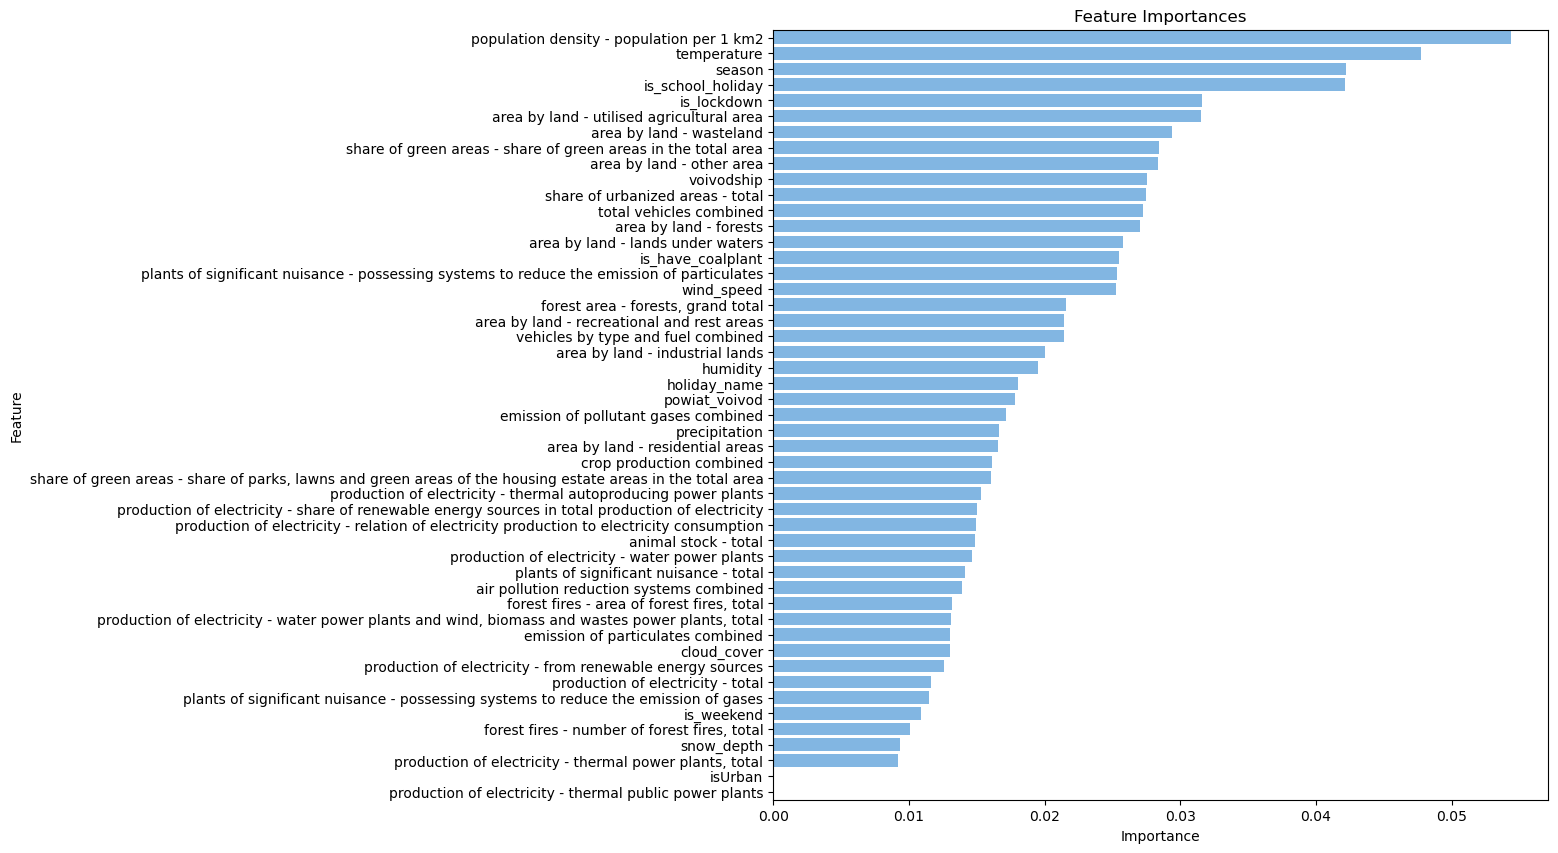

In [42]:
feature_names = train.columns.tolist()
feature_names.remove('CAQI_level')

# Convert feature importances array to a pandas DataFrame
importances_df = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})

# Sort DataFrame by importance values in descending order
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plot horizontal bar graph using seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=importances_df,color='#72b7f2')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()